# Clustering customer dataset

## Dependencies

In [1]:
!pip install -q pca

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MultiLabelBinarizer
import re
from pandas.tseries.offsets import DateOffset
import unicodedata
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.cluster import adjusted_rand_score
from pca import pca
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
#from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

In [3]:
from google.colab import drive

## Aux functions

In [4]:
def clean(text):
  """
  Clean text by removing accents and setting case to lower.
  """
  text = text.lower()
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf_8','ignore')
  text = text.strip()
  return text

In [5]:
# Test data completion
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order

    Args:
        data(dataset) : A dataset with variables

    Returns:
        A specific dataframe with completion rate for each variable.
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}

    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())

    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Completion rate", "Number of missing values"]).sort_values(by="Completion rate", ascending=False)

In [6]:
def calc_period(data, nbmonths):
    temp = data[data.order_purchase_timestamp <= (data.order_purchase_timestamp.min() + DateOffset(months=3+nbmonths))]
    temp.drop(columns=['order_purchase_timestamp'], inplace=True)
    return temp

In [7]:
def calcKmeans(df_pca):
  #var_thr = VarianceThreshold(threshold = 0.1) # remove constant and quasi-constant variables where 90% of the values are similar
  #var_thr.fit(df_pca)
  #concol = [column for column in df_pca.columns if column not in df_pca.columns[var_thr.get_support()]]
  #df_pca.drop(concol, axis=1, inplace=True)
  mm = MinMaxScaler()
  df_pca = pd.DataFrame(mm.fit_transform(df_pca), columns=df_pca.columns, index=df_pca.index)
  kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=1000, random_state=20).fit(df_pca)
  #clusters = kmeans.predict(df_pca)
  cluster_labels = kmeans.labels_
  return  cluster_labels

## Data

In [8]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
path = '/content/drive/My Drive/OCL/P5/'

In [10]:
rfm_data = pd.read_csv(path+'data/rfm_log.csv')

In [11]:
rfm_data.set_index('customer_id', inplace=True)

## Clustering on RFM data

In [12]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

In [13]:
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_data.index, columns=rfm_data.columns)
rfm_scaled.head()

,recency,frequency,monetary
customer_id,,,
0001fd6190edaaf884bcaf3d49edf079,1.182129,-0.347046,1.114894
0002414f95344307404f0ace7a26f1d5,0.805097,-0.347046,0.996067
000379cdec625522490c315e70c7a9fb,-0.146167,-0.347046,0.283105
0004164d20a9e969af783496f3408652,1.099366,-0.347046,-0.268196
000419c5494106c306a97b5635748086,0.040816,-0.347046,-0.784955


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

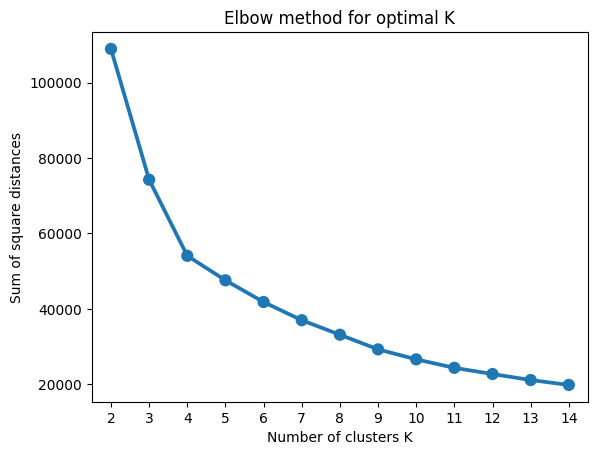

In [14]:
#wcss stands for within cluster sum of squares
wcss={}

for k in range(2,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(rfm_scaled)
    wcss[k] = km.inertia_

#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

In [15]:
kmean_model = KMeans(n_clusters=4, init='k-means++', max_iter=1000, random_state=20)
kmean_model.fit(rfm_scaled)

#find the clusters for the records given in our dataset
rfm_data['Cluster'] = kmean_model.labels_

#check the datset
rfm_data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,recency,frequency,monetary,Cluster
customer_id,,,,
0001fd6190edaaf884bcaf3d49edf079,6.304,0.0,5.275,3
0002414f95344307404f0ace7a26f1d5,5.935,0.0,5.189,3
000379cdec625522490c315e70c7a9fb,5.004,0.0,4.673,3
0004164d20a9e969af783496f3408652,6.223,0.0,4.274,1
000419c5494106c306a97b5635748086,5.187,0.0,3.900,1


In [16]:
clusters = rfm_data.Cluster.value_counts().to_frame()

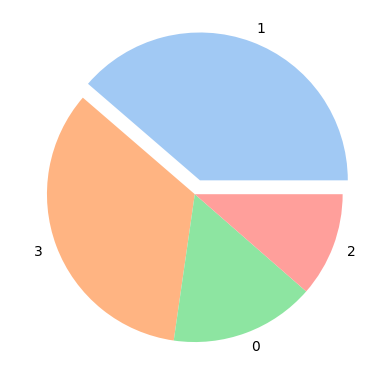

In [17]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(x=clusters['Cluster'], labels=clusters.index.values, colors=colors, explode=[0.1, 0, 0, 0]);

#### Davies Bouldin Indicator

0.829691999148745


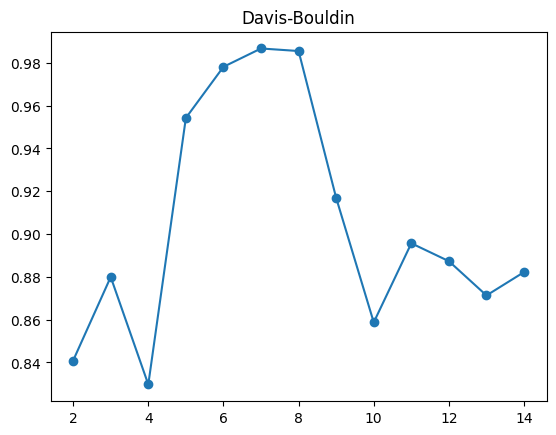

In [18]:
DB=[]
for num_clusters in range(2, 15):
    cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
    cls = cls.fit(rfm_scaled)
    db = metrics.davies_bouldin_score(rfm_scaled,cls.labels_)
    DB.append(db)

print(min(DB))
plt.plot(np.arange(2, 15),DB,marker='o')
plt.title('Davis-Bouldin')
plt.show()

#### Silhouette score

Max score : 0.55


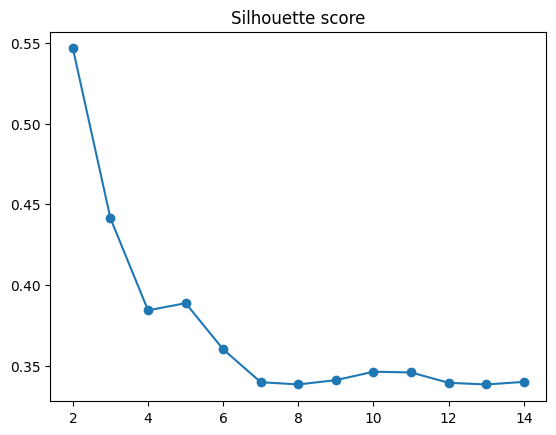

In [19]:
silhouettes=[]
for num_clusters in range(2, 15):
  cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
  cls.fit(rfm_scaled)
  silh = metrics.silhouette_score(rfm_scaled,cls.labels_)
  silhouettes.append(silh)

print("Max score : {:.2}".format(max(silhouettes)))
plt.plot(np.arange(2, 15),silhouettes,marker='o')
plt.title('Silhouette score')
plt.show()

### Hierarchical Clustering

In [20]:
rfm_scaled.shape

(56772, 3)

In [21]:
rfm_hier = rfm_scaled.sample(frac=1).reset_index(drop=True)

In [22]:
linkage_data = linkage(rfm_hier.head(2000), method='ward', metric='euclidean')

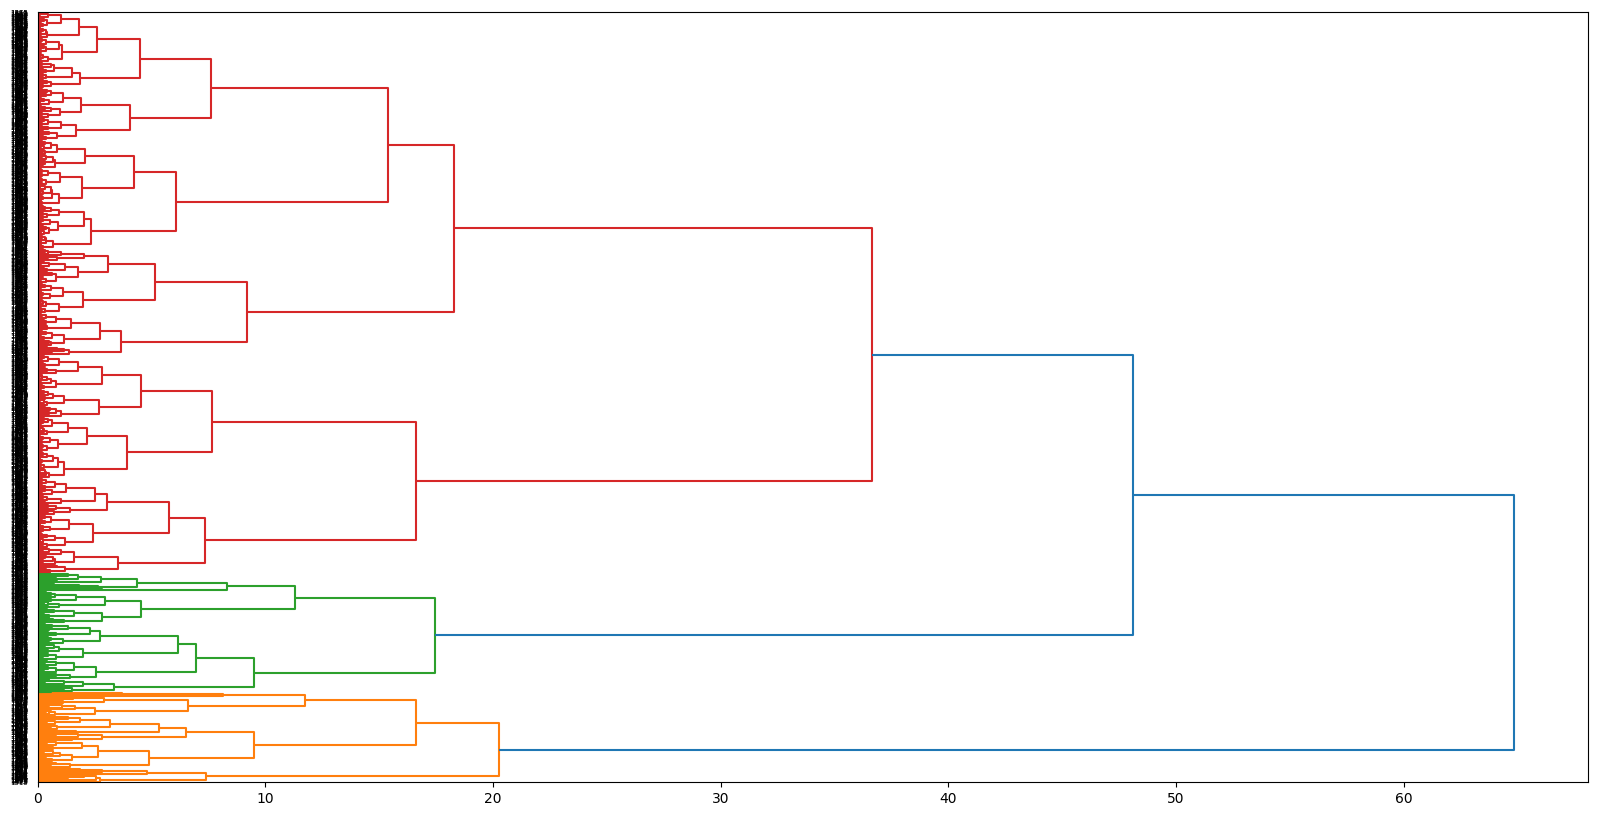

In [23]:
plt.figure(figsize=(20, 10) )
dendrogram(linkage_data,orientation="right")

plt.show()

## Clustering on The full dataset

### Preprocessing

In [24]:
client_data = pd.read_csv(path+'data/client_data_cleaned.csv')

In [25]:
client_data['preferred_category'].fillna('other category', inplace=True)

In [26]:
client_data['preferred_payment_type'].fillna('other payment type', inplace=True)

In [27]:
client_data['preferred_category'] = client_data['preferred_category'].apply(lambda x: [x])

In [28]:
client_data['preferred_payment_type'] = client_data['preferred_payment_type'].apply(lambda x: [x])

In [29]:
mlb = MultiLabelBinarizer()

In [30]:
pref_category = pd.DataFrame(mlb.fit_transform(client_data['preferred_category']), columns=mlb.classes_)

In [31]:
pref_payment_type = pd.DataFrame(mlb.fit_transform(client_data['preferred_payment_type']), columns=mlb.classes_)

**Categorizing cities using population quartiles**

In [32]:
city_population = pd.read_csv(path+'data/brazil_population.csv')

In [33]:
client_data['customer_city'] = client_data['customer_city'].apply(lambda x: clean(x))

In [34]:
city_population['City '] = city_population['City '].apply(lambda x: clean(x))

In [35]:
population_dict= {}
for idx, row in city_population.iterrows():
  population_dict[row['City ']] = row['2021\nEstimate ']

In [36]:
client_data['city_population'] = client_data['customer_city'].map(population_dict)

In [37]:
client_data['city_population'].fillna(0, inplace=True)

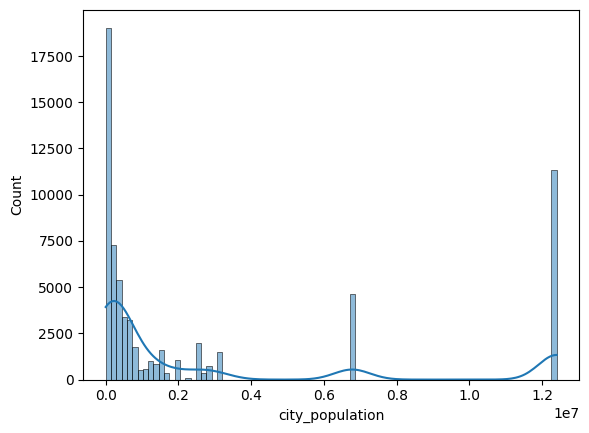

In [38]:
sns.histplot(client_data['city_population'], kde=True);

In [39]:
client_data['city_population'].quantile([0.25, 0.5, 0.75])

0.25     123090.0
0.50     516524.0
0.75    3094325.0
Name: city_population, dtype: float64

In [40]:
city_sizes = pd.qcut(client_data['city_population'], [0, .25, 0.5, 0.75, 1], labels=['towns or missing info', 'small city', 'medium city', 'big city'])

In [41]:
city_sizes

0        towns or missing info
1                     big city
2                   small city
3        towns or missing info
4                   small city
                 ...          
66641    towns or missing info
66642    towns or missing info
66643                 big city
66644               small city
66645              medium city
Name: city_population, Length: 66646, dtype: category
Categories (4, object): ['towns or missing info' < 'small city' < 'medium city' < 'big city']

In [42]:
client_data['customer_city_categorical'] = city_sizes
client_data['customer_city_categorical'] = client_data['customer_city_categorical'].astype(object)
client_data['customer_city_categorical'] = client_data['customer_city_categorical'].apply(lambda x: [x])

In [43]:
cities = pd.DataFrame(mlb.fit_transform(client_data['customer_city_categorical']), columns=mlb.classes_)

In [44]:
cities

,big city,medium city,small city,towns or missing info
0,0,0,0,1
1,1,0,0,0
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
66641,0,0,0,1
66642,0,0,0,1
66643,1,0,0,0
66644,0,0,1,0


**Putting it all together**

In [45]:
client_data = pd.concat([client_data, pref_category, pref_payment_type, cities], axis=1)

In [46]:
client_data.drop(columns=['preferred_category', 'preferred_payment_type', 'customer_city', 'customer_city_categorical'], inplace=True)

#### Correlation and recurrant features

<ipython-input-47-0df73bc81848>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = client_data.corr(method='spearman')
<ipython-input-47-0df73bc81848>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


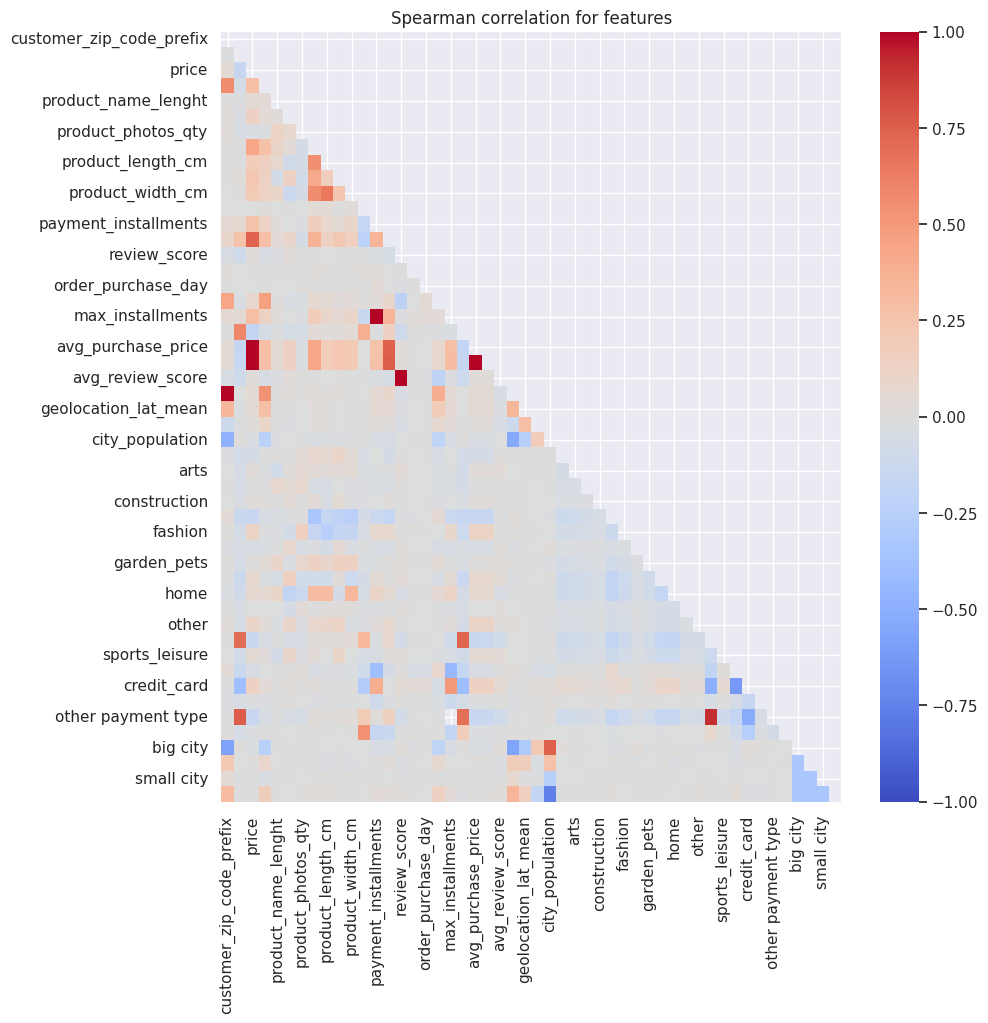

In [47]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
plt.title('Spearman correlation for features')

corr = client_data.corr(method='spearman')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

In [48]:
client_data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_score',
       'order_purchase_hour', 'order_purchase_day', 'delivery_delay',
       'max_installments', 'nb_products', 'avg_purchase_price',
       'max_purchase_price', 'avg_review_score', 'geolocation_zip_code_prefix',
       'geolocation_city', 'geolocation_state', 'geolocation_lat_mean',
 

In [49]:
frequenters = client_data.groupby('customer_id')['order_purchase_timestamp'].count().to_frame().reset_index()

In [50]:
non_frequenters = client_data.groupby('customer_id')['order_purchase_timestamp'].count().to_frame().reset_index()

In [51]:
frequenters_ids = frequenters[frequenters['order_purchase_timestamp'] > 1]['customer_id'].tolist()

In [52]:
non_frequenters_ids = non_frequenters[non_frequenters['order_purchase_timestamp'] == 1]['customer_id'].tolist()

In [53]:
len(non_frequenters_ids)

49896

In [54]:
data = client_data[['customer_id', 'order_id',
                    'delivery_delay', 'max_installments', 'order_purchase_day',
                    'order_purchase_hour', 'nb_products', 'avg_purchase_price',
                    'avg_review_score', 'appliances', 'arts', 'auto',
                    'construction', 'electronics', 'fashion', 'food_drinks',
                    'garden_pets', 'health_beauty', 'home', 'office', 'other payment type',
                    'sports_leisure', 'boleto', 'credit_card', 'debit_card',
                    'other category', 'voucher', 'big city', 'medium city', 'small city', 'towns or missing info']]

In [55]:
client_data_copy = client_data.copy(deep=True)

In [56]:
frequenters_data = client_data_copy[client_data_copy.index.isin(frequenters_ids)]

In [57]:
frequenters_data = frequenters_data[['order_id',
                    'delivery_delay', 'max_installments', 'order_purchase_day',
                    'order_purchase_hour', 'nb_products', 'avg_purchase_price',
                    'avg_review_score', 'appliances', 'arts', 'auto',
                    'construction', 'electronics', 'fashion', 'food_drinks',
                    'garden_pets', 'health_beauty', 'home', 'office', 'other payment type',
                    'sports_leisure', 'boleto', 'credit_card', 'debit_card',
                    'other category', 'voucher', 'big city', 'medium city', 'small city', 'towns or missing info']]

In [58]:
data.set_index('customer_id', inplace=True)

In [59]:
data =  pd.merge(data, rfm_data, how='left', on='customer_id')
#frequenters_data = pd.merge(frequenters_data, rfm_data, how='left', on='customer_id')

In [60]:
data.to_csv(path+'data/client_data_for_clustering.csv', index=False)
#frequenters_data.to_csv(path+'data/frequenters_client_data_for_clustering.csv', index=False)

In [61]:
data.drop(columns=['nb_products'], inplace=True)
#frequenters_data.drop(columns=['nb_products'], inplace=True)

In [62]:
data.drop(columns=['Cluster'], inplace=True)
#frequenters_data.drop(columns=['Cluster'], inplace=True)

**Let's check the correlation now**

<ipython-input-63-0f2f1e24cfc2>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr(method='spearman')
<ipython-input-63-0f2f1e24cfc2>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


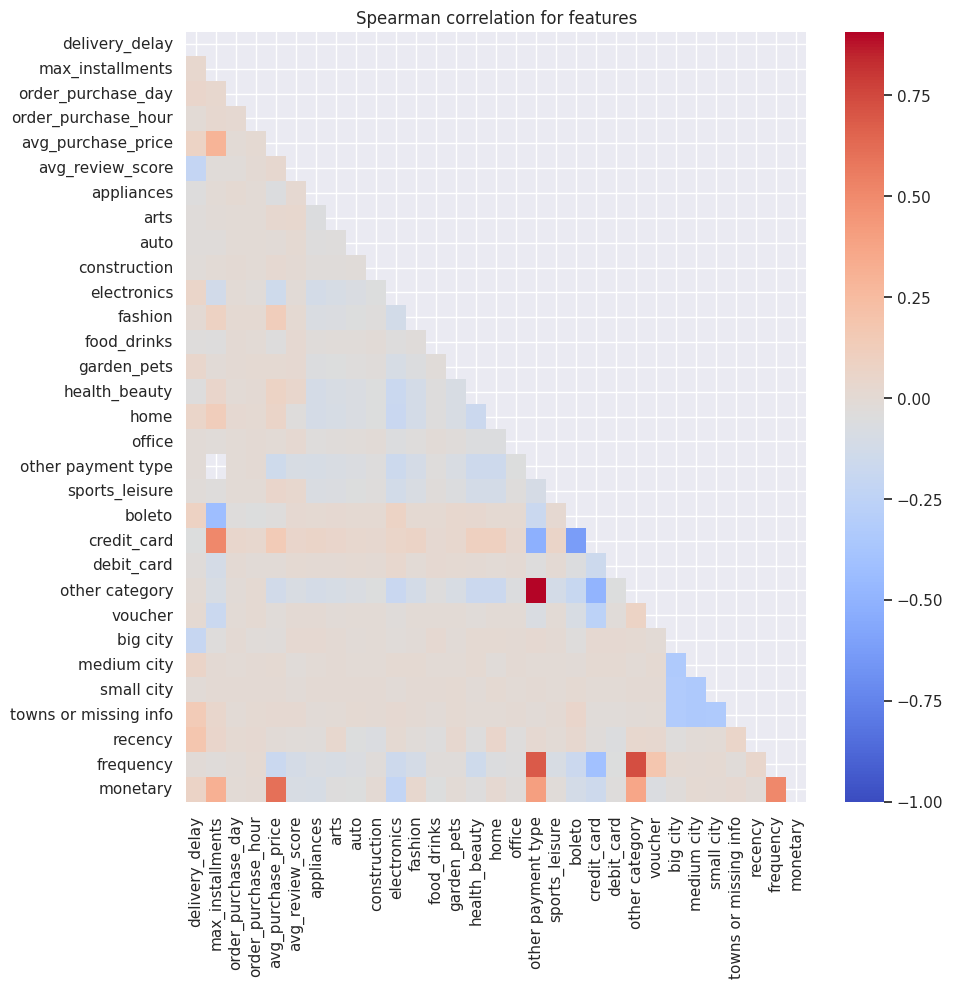

In [63]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
plt.title('Spearman correlation for features')

corr = data.corr(method='spearman')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

### Main clustering

In [64]:
data.drop(columns=['order_id'], inplace=True)
frequenters_data.drop(columns=['order_id'], inplace=True)

In [65]:
test_completion(data)

,Completion rate,Number of missing values
delivery_delay,100.00,0
health_beauty,100.00,0
towns or missing info,100.00,0
small city,100.00,0
medium city,100.00,0
big city,100.00,0
voucher,100.00,0
other category,100.00,0
debit_card,100.00,0
credit_card,100.00,0


In [66]:
data.drop(data[data['recency'].isna()].index.values, inplace=True)
data.drop(data[data['monetary'].isna()].index.values, inplace=True)
data.drop(data[data['frequency'].isna()].index.values, inplace=True)

In [67]:
data['max_installments'].fillna(0, inplace=True)

In [68]:
data.shape

(66623, 31)

In [69]:
data.drop_duplicates(inplace=True)

In [70]:
#frequenters_data.drop(frequenters_data[frequenters_data['recency'].isna()].index.values, inplace=True)
#frequenters_data.drop(frequenters_data[frequenters_data['monetary'].isna()].index.values, inplace=True)
#frequenters_data.drop(frequenters_data[frequenters_data['frequency'].isna()].index.values, inplace=True)

In [71]:
#frequenters_data['max_installments'].fillna(0, inplace=True)

In [72]:
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(data)

In [73]:
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
data_scaled.head()

,delivery_delay,max_installments,order_purchase_day,order_purchase_hour,avg_purchase_price,avg_review_score,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other payment type,sports_leisure,boleto,credit_card,debit_card,other category,voucher,big city,medium city,small city,towns or missing info,recency,frequency,monetary
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,0.043269,0.041667,0.333333,0.521739,0.285859,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.795232,0.0,0.584774
840be0730010e9580efd289bc9f37706,0.067308,0.083333,0.666667,0.652174,0.166757,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.924511,0.0,0.540473
daf813bc2e41c86027d086e8dfb35571,0.038462,0.125000,0.000000,0.565217,0.322470,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.942848,0.0,0.600853
272b46feddddc51904608ddd90feee33,0.038462,0.041667,0.333333,0.608696,0.431432,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.849175,0.0,0.633122
8ebbeb09e94d1e789142983f73faa9cd,0.014423,0.083333,0.000000,0.695652,0.123665,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.807304,0.0,0.505797


#### A quick look with tSNE

In [74]:
# Don't launch this cell all over again, it's very time consuming.
#tsne = TSNE(n_components=2, verbose=1, random_state=123)
#z = tsne.fit_transform(data_scaled)

In [75]:
#tsne_df = pd.DataFrame()
#tsne_df["comp-1"] = z[:,0]
#tsne_df["comp-2"] = z[:,1]

#sns.scatterplot(x="comp-1", y="comp-2",
#                palette=sns.color_palette("hls", 3),
#                data=tsne_df).set(title="data T-SNE projection")

#### K-means inertia and elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

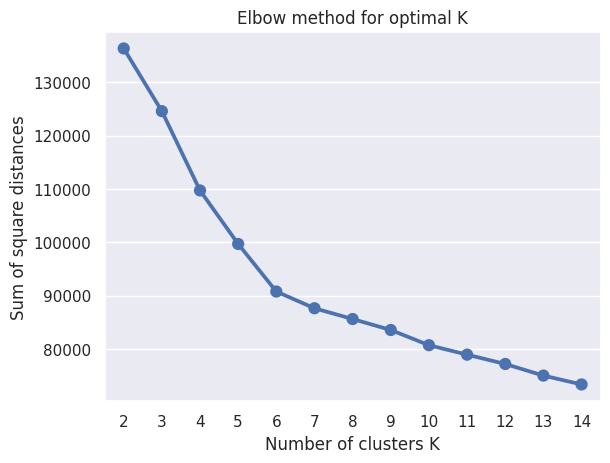

In [76]:
#wcss stands for within cluster sum of squares
wcss={}

for k in range(2,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(data_scaled)
    wcss[k] = km.inertia_

#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

#### Davies bouldin Indicator

1.563169434329101


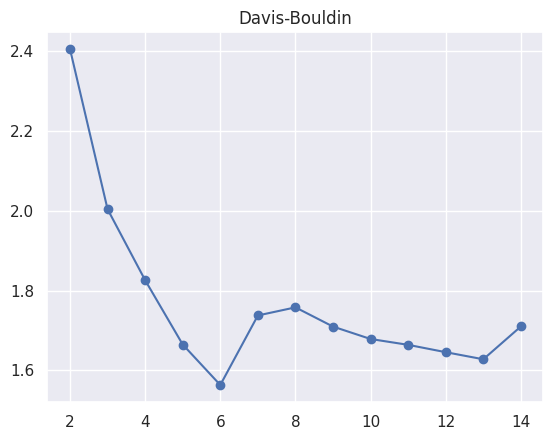

In [77]:
DB=[]
for num_clusters in range(2, 15):
    cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
    cls = cls.fit(data_scaled)
    db = metrics.davies_bouldin_score(data_scaled,cls.labels_)
    DB.append(db)

print(min(DB))
plt.plot(np.arange(2, 15),DB,marker='o')
plt.title('Davis-Bouldin')
plt.show()

#### Silhoutte score

Max score : 0.26


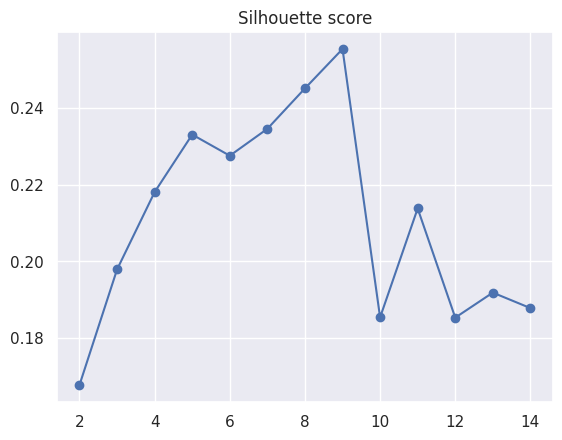

In [78]:
silhouettes=[]
for num_clusters in range(2, 15):
  cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
  cls.fit(data_scaled)
  silh = metrics.silhouette_score(data_scaled,cls.labels_)
  silhouettes.append(silh)

print("Max score : {:.2}".format(max(silhouettes)))
plt.plot(np.arange(2, 15),silhouettes,marker='o')
plt.title('Silhouette score')
plt.show()

### Testing out the clusters

In [79]:
kmean_client_model = KMeans(n_clusters=6, init='k-means++', max_iter=1000, random_state=20)
kmean_client_model.fit(data_scaled)

#find the clusters for the records given in our dataset
data['Cluster'] = kmean_client_model.labels_

#check the datset
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,delivery_delay,max_installments,order_purchase_day,order_purchase_hour,avg_purchase_price,avg_review_score,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other payment type,sports_leisure,boleto,credit_card,debit_card,other category,voucher,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,10,1.0,2,12,79.79,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.204,0.0,4.478,1
840be0730010e9580efd289bc9f37706,15,2.0,4,15,46.90,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,6.050,0.0,4.073,2
daf813bc2e41c86027d086e8dfb35571,9,3.0,0,13,89.90,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,6.170,0.0,4.625,0
272b46feddddc51904608ddd90feee33,9,1.0,2,14,119.99,5.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.557,0.0,4.920,1
8ebbeb09e94d1e789142983f73faa9cd,4,2.0,0,16,35.00,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,5.283,0.0,3.756,0


In [80]:
aggregation_dict = {'delivery_delay': 'min',
                    'max_installments': 'median',
                    'order_purchase_day': 'median',
                    'avg_purchase_price': 'mean',
                    'avg_review_score': 'mean',
                    'recency': 'mean',
                    'frequency': 'mean',
                    'monetary': 'mean'
                    }
radar_df = data.groupby('Cluster').agg(aggregation_dict)

In [81]:
radar_df

,delivery_delay,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,recency,frequency,monetary
Cluster,,,,,,,,
0,2,2.0,3.0,75.562502,4.153293,5.140917,0.121874,4.486340
1,2,2.0,3.0,76.720617,4.217738,5.225497,0.113239,4.521041
2,1,2.0,3.0,73.312372,4.211633,5.059958,0.117553,4.434096
3,1,2.0,3.0,76.161722,4.122705,5.121026,0.119127,4.505500
4,2,0.0,3.0,55.398722,3.810663,5.199510,0.849796,5.427883
5,2,1.0,2.0,67.131137,4.178516,5.202142,0.078628,4.398670


In [82]:
mm_scaler = MinMaxScaler()
radar_df_scaled = pd.DataFrame(mm_scaler.fit_transform(radar_df), columns=radar_df.columns, index=radar_df.index.values)

In [83]:
radar_df_scaled
for column in radar_df_scaled.columns:
  radar_df_scaled[column] = radar_df_scaled[column].apply(lambda x: x * 10)

In [84]:
categories = ['Delivery delay', 'Average maximum installments',
              'Order purchase day', 'Average purchase price',
              'Average review score',
              'Average Recency', 'Average Frequency', 'Average Monetary']

In [85]:
cluster_1 = radar_df_scaled.loc[0].tolist()
cluster_2 = radar_df_scaled.loc[1].tolist()
cluster_3 = radar_df_scaled.loc[2].tolist()
cluster_4 = radar_df_scaled.loc[3].tolist()
cluster_5 = radar_df_scaled.loc[4].tolist()
cluster_6 = radar_df_scaled.loc[5].tolist()

In [86]:
categories.append(categories[0])
cluster_1.append(cluster_1[0])
cluster_2.append(cluster_2[0])
cluster_3.append(cluster_3[0])
cluster_4.append(cluster_4[0])
cluster_5.append(cluster_5[0])
cluster_6.append(cluster_6[0])

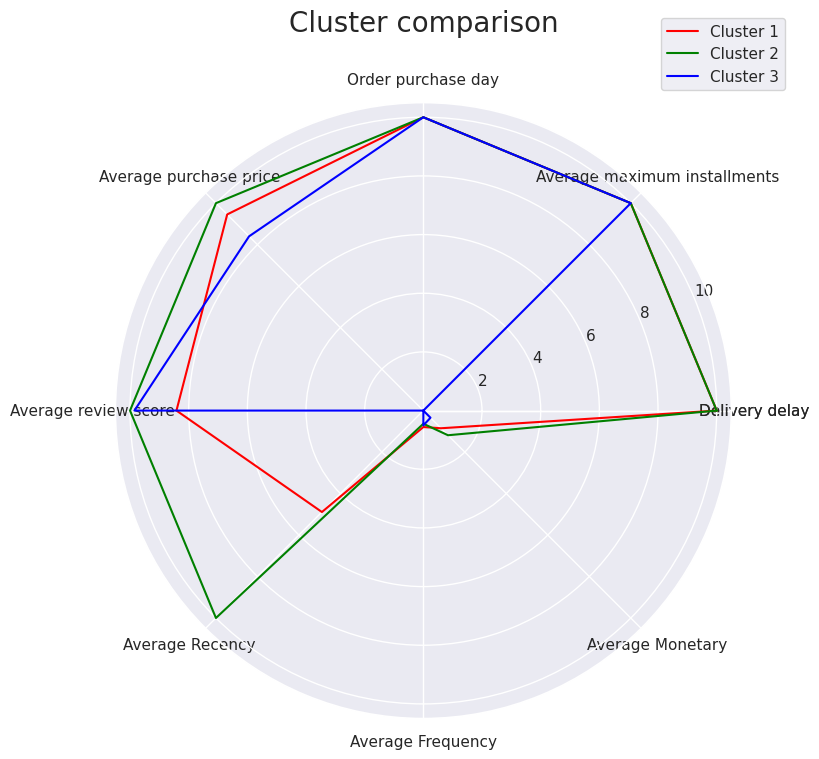

In [87]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_1, label='Cluster 1',c='red')
plt.plot(label_loc, cluster_2, label='Cluster 2',c='green')
plt.plot(label_loc, cluster_3, label='Cluster 3',c='blue')
plt.title('Cluster comparison\n', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
plt.show()

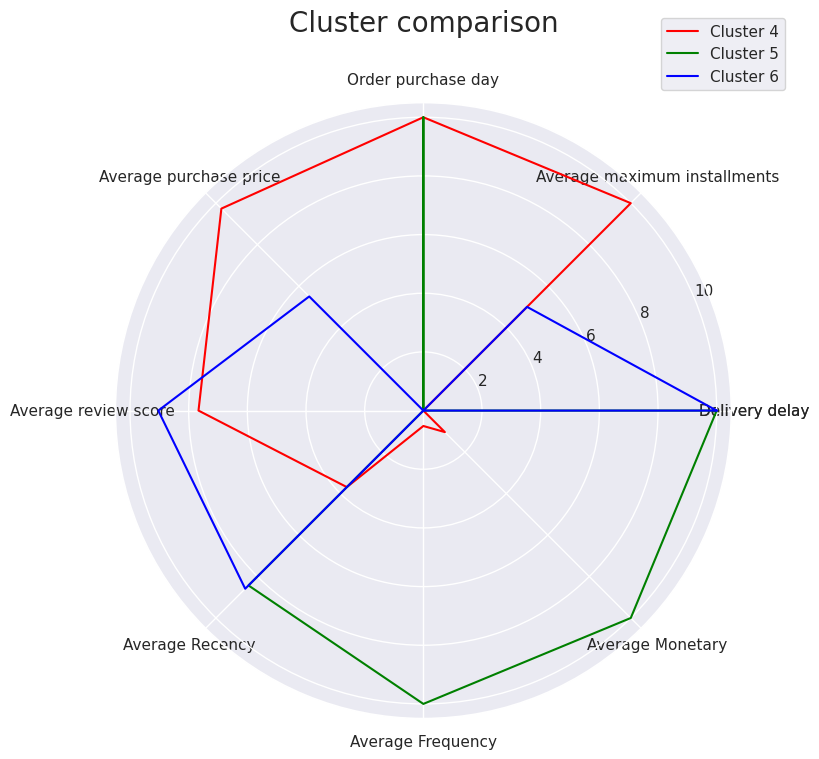

In [88]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_4, label='Cluster 4',c='red')
plt.plot(label_loc, cluster_5, label='Cluster 5',c='green')
plt.plot(label_loc, cluster_6, label='Cluster 6',c='blue')
plt.title('Cluster comparison\n', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
plt.show()

## Clustering with a transformed dataset

### Filtering with variance threshold

In [89]:
data_var = data.copy(deep=True)
data_var.drop(columns=['Cluster', 'delivery_delay', 'order_purchase_hour'], inplace=True)

In [91]:
# If executing alone, execute this cell
#data_var.drop(columns=['delivery_delay', 'order_purchase_hour'], inplace=True)

In [92]:
var_thr = VarianceThreshold(threshold = 0.1) # remove constant and quasi-constant variables where 90% of the values are similar
var_thr.fit(data_var)

VarianceThreshold(threshold=0.1)

In [93]:
concol = [column for column in data_var.columns
          if column not in data_var.columns[var_thr.get_support()]]

for features in concol:
    print(features)

appliances
arts
auto
construction
fashion
food_drinks
garden_pets
office
other payment type
sports_leisure
debit_card
other category
voucher


In [94]:
data_var.shape

(63981, 29)

In [95]:
data_var.drop(concol,axis=1, inplace=True)

In [96]:
print(data_var.head())
print(data_var.shape)

                                  max_installments  order_purchase_day  \
customer_id                                                              
8a2e7ef9053dea531e4dc76bd6d853e6               1.0                   2   
840be0730010e9580efd289bc9f37706               2.0                   4   
daf813bc2e41c86027d086e8dfb35571               3.0                   0   
272b46feddddc51904608ddd90feee33               1.0                   2   
8ebbeb09e94d1e789142983f73faa9cd               2.0                   0   

                                  avg_purchase_price  avg_review_score  \
customer_id                                                              
8a2e7ef9053dea531e4dc76bd6d853e6               79.79               5.0   
840be0730010e9580efd289bc9f37706               46.90               5.0   
daf813bc2e41c86027d086e8dfb35571               89.90               5.0   
272b46feddddc51904608ddd90feee33              119.99               5.0   
8ebbeb09e94d1e789142983f73faa9cd     

#### PCA on variance dataset

In [97]:
X_scaled = pd.DataFrame(preprocessing.scale(data_var),columns = data_var.columns)
model = pca(n_components=11)
data_transformed = model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [16] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


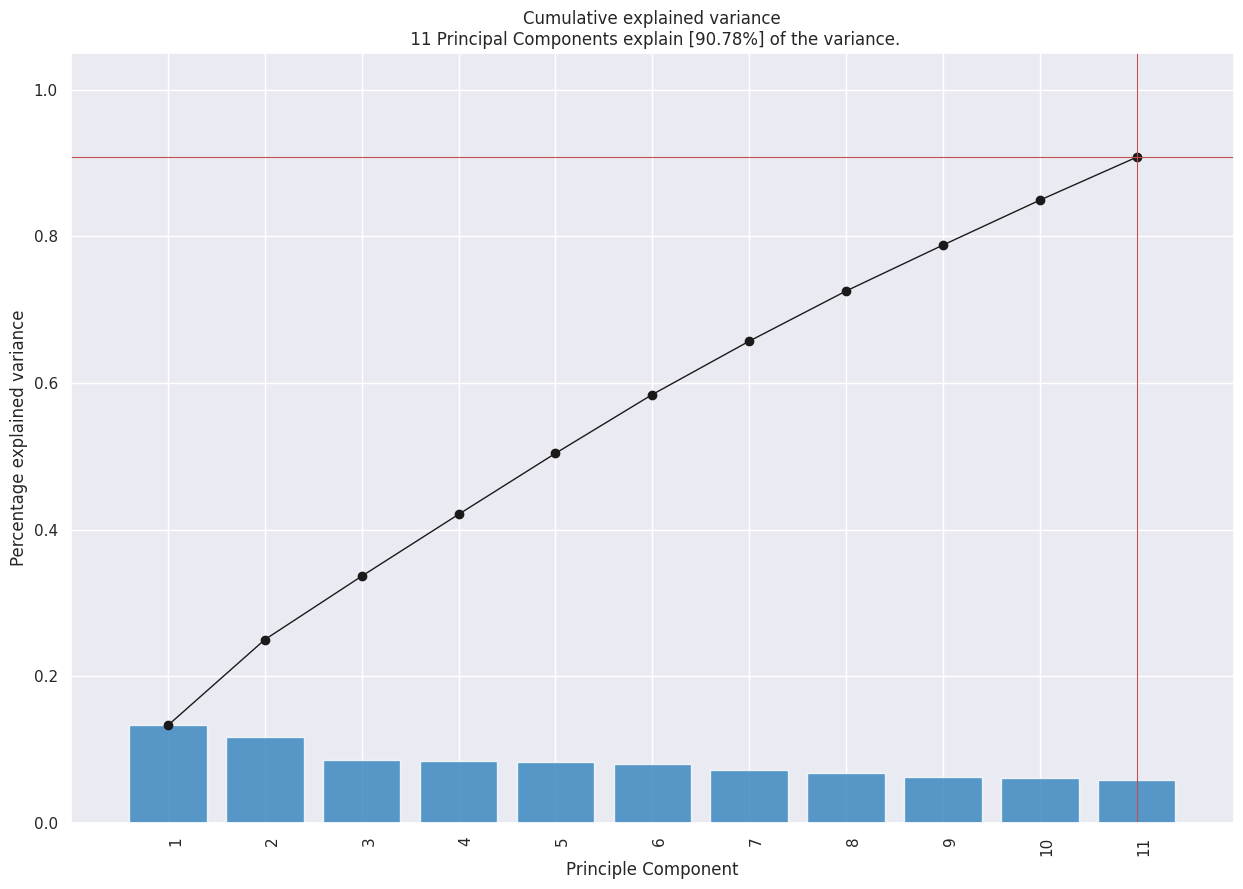

In [98]:
model.plot();

In [99]:
X_scaled = pd.DataFrame(preprocessing.scale(data_var),columns = data_var.columns)
model = pca(n_components=11)
data_transformed = model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [16] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


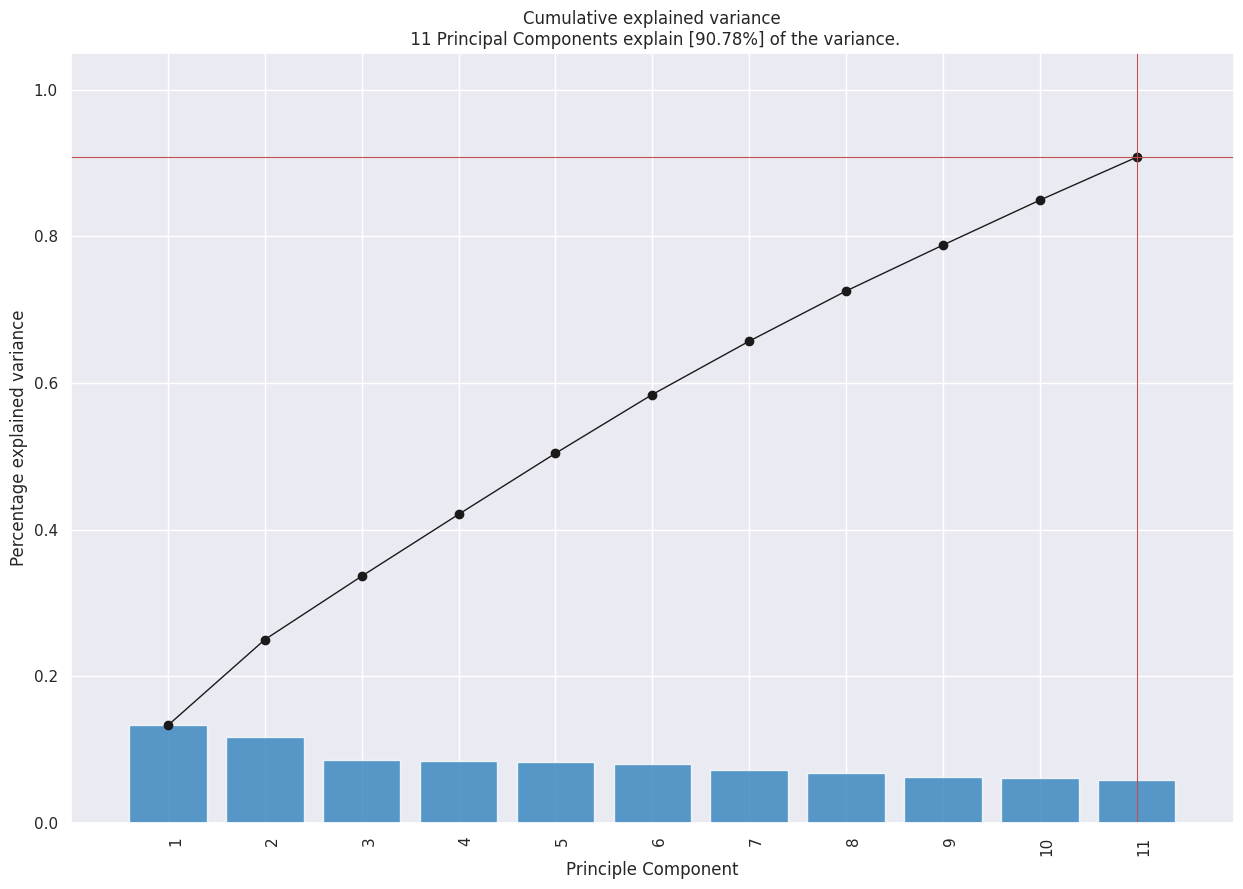

In [100]:
model.plot();

**Let's choose n_components = 11** which explain 90% variance

In [101]:
pca_model = PCA(n_components=11, random_state=42)
data_transformed = pca_model.fit_transform(X_scaled)
data_transformed = pd.DataFrame(data_transformed)

In [102]:
data_transformed

,0,1,2,3,4,5,6,7,8,9,10
0,0.044892,-1.160972,1.671978,0.165183,0.634801,-1.164496,-1.196294,1.422339,0.626306,0.252119,-0.249085
1,0.744535,-0.912302,-1.087791,-1.054454,1.512532,-0.588739,2.207120,-0.706038,-0.293391,0.134370,-0.918358
2,1.211037,0.030685,0.179938,-1.664258,-1.468470,-0.384839,1.788548,-0.466961,1.429515,-0.904538,-0.852476
3,0.706849,0.205204,1.794173,0.028441,0.769743,-0.269592,-0.634514,0.060949,0.561957,0.085702,-0.594841
4,0.363856,-1.341340,-0.252117,-1.062290,-1.488752,1.331088,-1.271600,-1.489447,0.498468,-1.700733,0.200900
...,...,...,...,...,...,...,...,...,...,...,...
63976,0.603723,-0.125126,1.392076,-0.021714,0.698811,-0.810232,-0.708603,-0.299411,-0.084120,0.103849,1.008037
63977,-0.039582,-1.320844,1.353355,-0.126642,0.768038,-1.067105,-0.675391,-0.996771,-0.179233,0.558180,-0.612469
63978,1.439657,0.850239,-0.591148,-0.434236,1.462035,1.148526,0.342491,1.450271,-1.457466,0.952922,-1.111051
63979,0.201226,-0.756125,-0.599973,-1.292842,-1.460367,0.048486,-0.620934,-0.304220,-0.000195,0.998414,0.525095


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

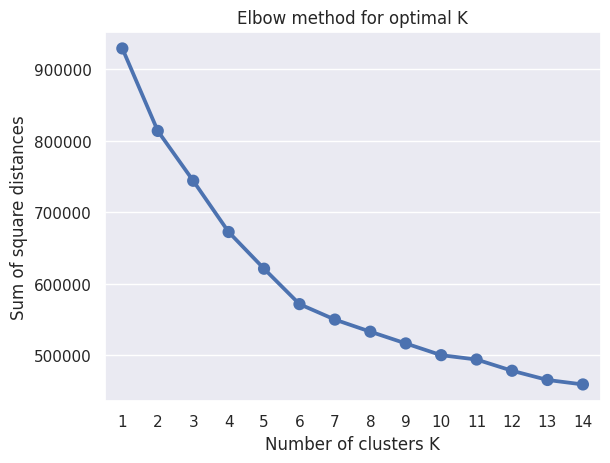

In [103]:
wcss={}

for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(data_transformed)
    wcss[k] = km.inertia_

#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

#### Davies - bouldin

1.6060258763897357


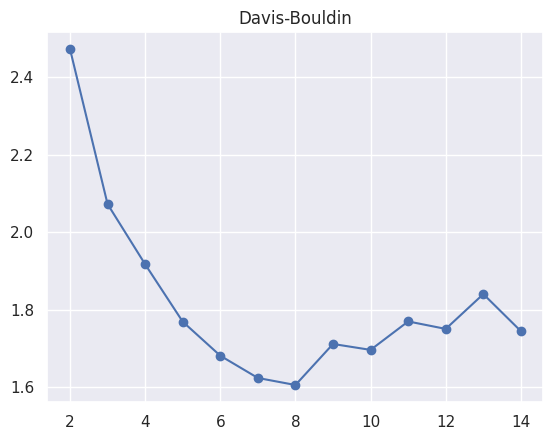

In [104]:
DB=[]
for num_clusters in range(2, 15):
    cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
    cls = cls.fit(data_transformed)
    db = metrics.davies_bouldin_score(data_transformed,cls.labels_)
    DB.append(db)

print(min(DB))
plt.plot(np.arange(2, 15),DB,marker='o')
plt.title('Davis-Bouldin')
plt.show()

Max score : 0.21


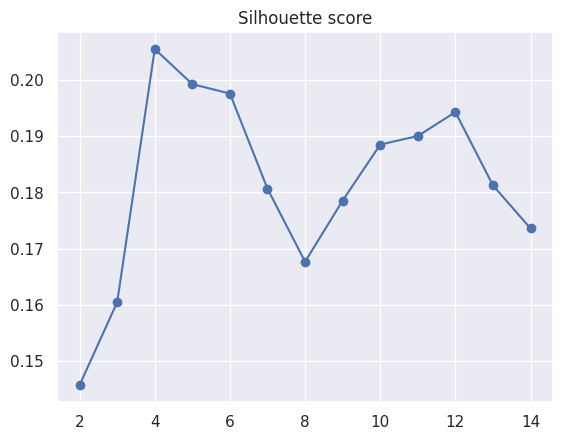

In [105]:
silhouettes=[]
for num_clusters in range(2, 15):
  cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
  cls.fit(data_transformed)
  silh = metrics.silhouette_score(data_transformed,cls.labels_)
  silhouettes.append(silh)

print("Max score : {:.2}".format(max(silhouettes)))
plt.plot(np.arange(2, 15),silhouettes,marker='o')
plt.title('Silhouette score')
plt.show()

### CLustering without PCA

In [106]:
data_var

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary
customer_id,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,1.0,2,79.79,5.0,1,0,0,0,1,0,0,0,1,5.204,0.0,4.478
840be0730010e9580efd289bc9f37706,2.0,4,46.90,5.0,0,0,1,0,1,1,0,0,0,6.050,0.0,4.073
daf813bc2e41c86027d086e8dfb35571,3.0,0,89.90,5.0,0,0,1,0,1,0,0,1,0,6.170,0.0,4.625
272b46feddddc51904608ddd90feee33,1.0,2,119.99,5.0,0,0,0,0,1,0,0,0,1,5.557,0.0,4.920
8ebbeb09e94d1e789142983f73faa9cd,2.0,0,35.00,4.0,0,1,0,0,1,0,0,1,0,5.283,0.0,3.756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486ce94ccf26c511ab93d31fefd5de0e,2.0,3,79.60,3.0,0,0,0,0,1,0,0,0,1,4.875,0.0,4.554
3d7697c0971cb2606444adae322d8bb3,1.0,4,29.00,5.0,0,0,0,0,1,0,0,0,1,5.628,0.0,3.786
d0d7086dea6fcf42b9b690b9f3745c58,1.0,6,199.99,5.0,0,0,0,0,1,1,0,0,0,5.591,0.0,5.346


In [107]:
var_thr_1 = VarianceThreshold(threshold=0) # remove constant and quasi-constant variables where 90% of the values are similar
var_thr_1.fit(data_var)

VarianceThreshold(threshold=0)

In [108]:
#data_var.drop(columns=['order_purchase_timestamp'], inplace=True)

In [109]:
mm = MinMaxScaler()
data_var_scaled = pd.DataFrame(mm.fit_transform(data_var), columns=data_var.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

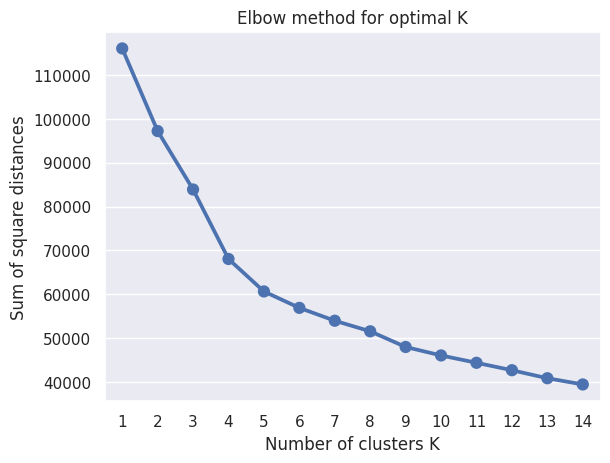

In [110]:
wcss={}

for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(data_var_scaled)
    wcss[k] = km.inertia_

#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

1.3150139950415218


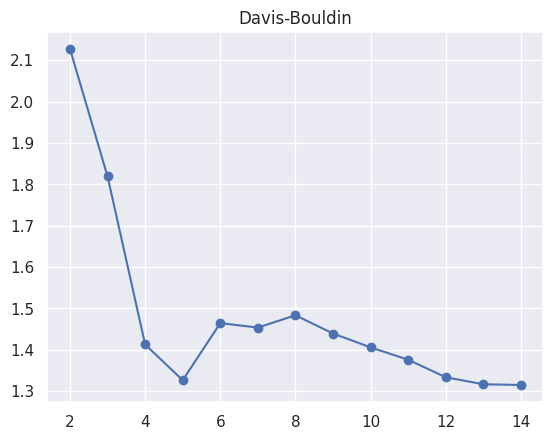

In [111]:
DB=[]
for num_clusters in range(2, 15):
    cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
    cls = cls.fit(data_var_scaled)
    db = metrics.davies_bouldin_score(data_var_scaled,cls.labels_)
    DB.append(db)

print(min(DB))
plt.plot(np.arange(2, 15),DB,marker='o')
plt.title('Davis-Bouldin')
plt.show()

Max score : 0.31


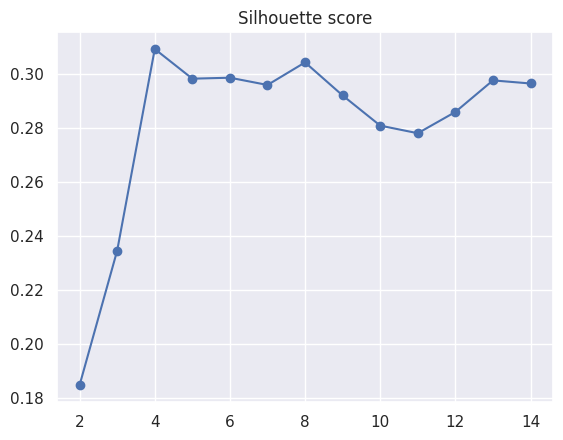

In [112]:
silhouettes=[]
for num_clusters in range(2, 15):
  cls = KMeans(n_clusters=num_clusters,n_init=50,init='k-means++')
  cls.fit(data_var_scaled)
  silh = metrics.silhouette_score(data_var_scaled,cls.labels_)
  silhouettes.append(silh)

print("Max score : {:.2}".format(max(silhouettes)))
plt.plot(np.arange(2, 15),silhouettes,marker='o')
plt.title('Silhouette score')
plt.show()

### Testing clusters with n_clusters=5

In [113]:
kmean_transformed_model = KMeans(n_clusters=5, init='k-means++', max_iter=1000, random_state=20)
kmean_transformed_model.fit(data_var_scaled)

#find the clusters for the records given in our dataset
data_var['Cluster'] = kmean_transformed_model.labels_

#check the datset
data_var.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,1.0,2,79.79,5.0,1,0,0,0,1,0,0,0,1,5.204,0.0,4.478,3
840be0730010e9580efd289bc9f37706,2.0,4,46.90,5.0,0,0,1,0,1,1,0,0,0,6.050,0.0,4.073,4
daf813bc2e41c86027d086e8dfb35571,3.0,0,89.90,5.0,0,0,1,0,1,0,0,1,0,6.170,0.0,4.625,0
272b46feddddc51904608ddd90feee33,1.0,2,119.99,5.0,0,0,0,0,1,0,0,0,1,5.557,0.0,4.920,3
8ebbeb09e94d1e789142983f73faa9cd,2.0,0,35.00,4.0,0,1,0,0,1,0,0,1,0,5.283,0.0,3.756,0


In [114]:
data_var

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,1.0,2,79.79,5.0,1,0,0,0,1,0,0,0,1,5.204,0.0,4.478,3
840be0730010e9580efd289bc9f37706,2.0,4,46.90,5.0,0,0,1,0,1,1,0,0,0,6.050,0.0,4.073,4
daf813bc2e41c86027d086e8dfb35571,3.0,0,89.90,5.0,0,0,1,0,1,0,0,1,0,6.170,0.0,4.625,0
272b46feddddc51904608ddd90feee33,1.0,2,119.99,5.0,0,0,0,0,1,0,0,0,1,5.557,0.0,4.920,3
8ebbeb09e94d1e789142983f73faa9cd,2.0,0,35.00,4.0,0,1,0,0,1,0,0,1,0,5.283,0.0,3.756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486ce94ccf26c511ab93d31fefd5de0e,2.0,3,79.60,3.0,0,0,0,0,1,0,0,0,1,4.875,0.0,4.554,3
3d7697c0971cb2606444adae322d8bb3,1.0,4,29.00,5.0,0,0,0,0,1,0,0,0,1,5.628,0.0,3.786,3
d0d7086dea6fcf42b9b690b9f3745c58,1.0,6,199.99,5.0,0,0,0,0,1,1,0,0,0,5.591,0.0,5.346,4


In [115]:
data_var[data_var['Cluster'] == 4].frequency.max()

3.738

In [116]:
aggregation_dict = { 'max_installments': 'mean',
                    'frequency': 'max',
                    'avg_purchase_price': 'mean',
                    'avg_review_score': 'mean',
                    'monetary': 'sum',
                    'electronics': 'mean',
                    'health_beauty': 'mean',
                    'home': 'mean',
                    'big city': 'mean',
                    'medium city': 'mean',
                    'small city': 'mean',
                    'towns or missing info': 'mean'
                    }
radar_df = data_var.groupby('Cluster').agg(aggregation_dict)

In [117]:
mm_scaler = MinMaxScaler()
radar_df_scaled = pd.DataFrame(mm_scaler.fit_transform(radar_df), columns=radar_df.columns, index=radar_df.index.values)

In [118]:
categories = ['Maximum installments',
              'Frequency rate', 'Average purchase price',
              'Average review score', 'Monetary gain',
              'Category: electronics',
              'Category: health and beauty',
              'Category: home', 'City size: big', 'City size: medium', 'City size: small', 'City size: town or missing info']

In [119]:
cluster_1 = radar_df_scaled.loc[0].tolist()
cluster_2 = radar_df_scaled.loc[1].tolist()
cluster_3 = radar_df_scaled.loc[2].tolist()

In [120]:
cluster_4 = radar_df_scaled.loc[3].tolist()
cluster_5 = radar_df_scaled.loc[4].tolist()

In [121]:
categories.append(categories[0])
cluster_1.append(cluster_1[0])
cluster_2.append(cluster_2[0])
cluster_3.append(cluster_3[0])

In [122]:
cluster_4.append(cluster_4[0])
cluster_5.append(cluster_5[0])

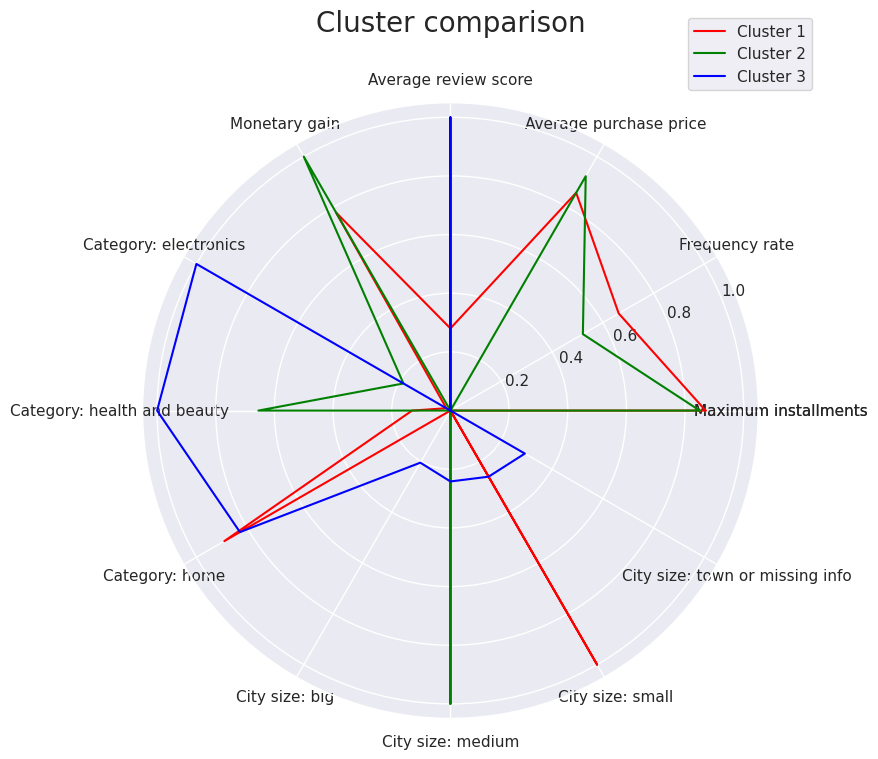

In [123]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_1, label='Cluster 1',c='red')
plt.plot(label_loc, cluster_2, label='Cluster 2',c='green')
plt.plot(label_loc, cluster_3, label='Cluster 3',c='blue')
plt.title('Cluster comparison\n', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
plt.show()

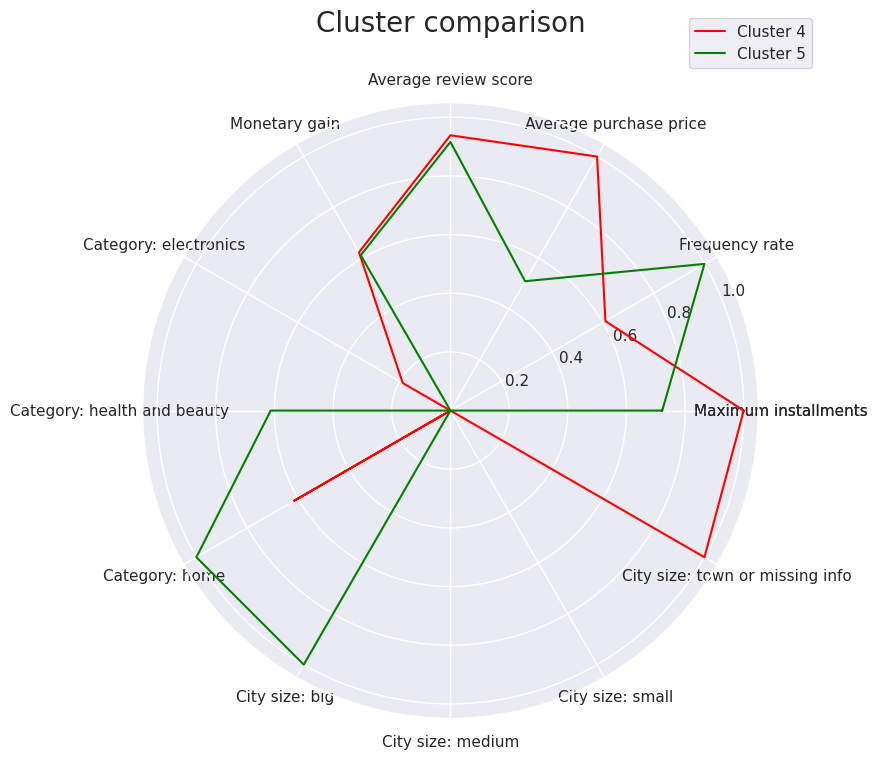

In [124]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_4, label='Cluster 4',c='red')
plt.plot(label_loc, cluster_5, label='Cluster 5',c='green')
plt.title('Cluster comparison\n', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
plt.show()

In [125]:
!ls '/content/My Drive'

ls: cannot access '/content/My Drive': No such file or directory


In [126]:
data_var.to_csv(path+'data/5_cluster_data.csv')

### Testing with 13 clusters

In [127]:
data_var_13 = data_var_scaled.copy(deep=True)

In [128]:
kmean_transformed_model_13 = KMeans(n_clusters=13, init='k-means++', max_iter=1000, random_state=20)
kmean_transformed_model_13.fit(data_var_13)

#find the clusters for the records given in our dataset
data_var_13['Cluster'] = kmean_transformed_model.labels_

#check the datset
data_var_13.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
0,0.041667,0.333333,0.285859,1.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.795232,0.0,0.584774,3
1,0.083333,0.666667,0.166757,1.00,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.924511,0.0,0.540473,4
2,0.125000,0.000000,0.322470,1.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.942848,0.0,0.600853,0
3,0.041667,0.333333,0.431432,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.849175,0.0,0.633122,3
4,0.083333,0.000000,0.123665,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.807304,0.0,0.505797,0


In [129]:
data_var_13.to_csv(path+'data/13_cluster_data.csv')

In [130]:
data_13 = pd.read_csv(path+'data/6_cluster_data.csv')

In [131]:
aggregation_dict = { 'max_installments': 'mean',
                    'frequency': 'max',
                    'avg_purchase_price': 'mean',
                    'avg_review_score': 'mean',
                    'monetary': 'sum',
                    'electronics': 'mean',
                    'health_beauty': 'mean',
                    'home': 'mean',
                    'big city': 'mean',
                    'medium city': 'mean',
                    'small city': 'mean',
                    'towns or missing info': 'mean'
                    }
radar_df = data_13.groupby('Cluster').agg(aggregation_dict)

In [132]:
radar_df

,max_installments,frequency,avg_purchase_price,avg_review_score,monetary,electronics,health_beauty,home,big city,medium city,small city,towns or missing info
Cluster,,,,,,,,,,,,
0,2.543751,3.178,73.179225,4.104866,60515.210,0.148884,0.142183,0.159394,0.000000,0.000000,1.000000,0.0
1,2.508091,2.944,73.638453,4.076200,63113.098,0.161675,0.153548,0.141100,0.000000,1.000000,0.000000,0.0
2,1.000000,2.079,66.848424,4.148067,36214.784,0.214710,0.161759,0.163213,0.290076,0.341815,0.368109,0.0
3,3.265248,3.091,77.340133,4.217509,47685.014,0.182975,0.159035,0.176135,0.000000,0.000000,0.000000,1.0
4,2.281184,3.738,70.723143,4.169905,58542.520,0.147665,0.152639,0.161654,1.000000,0.000000,0.000000,0.0
5,0.748513,3.091,64.266545,4.135479,26132.153,0.172706,0.114296,0.106364,0.000000,0.000000,0.000000,1.0


In [133]:
mm_scaler = MinMaxScaler()
radar_df_scaled = pd.DataFrame(mm_scaler.fit_transform(radar_df), columns=radar_df.columns, index=radar_df.index.values)

In [134]:
categories = ['Maximum installments',
              'Frequency rate', 'Average purchase price',
              'Average review score', 'Monetary gain',
              'Category: electronics',
              'Category: health and beauty',
              'Category: home', 'City size: big', 'City size: medium', 'City size: small', 'City size: town or missing info']

In [135]:
cluster_1 = radar_df_scaled.loc[0].tolist()
cluster_2 = radar_df_scaled.loc[1].tolist()
cluster_3 = radar_df_scaled.loc[2].tolist()

In [136]:
cluster_4 = radar_df_scaled.loc[3].tolist()
cluster_5 = radar_df_scaled.loc[4].tolist()
cluster_6 = radar_df_scaled.loc[5].tolist()

In [137]:
categories.append(categories[0])
cluster_1.append(cluster_1[0])
cluster_2.append(cluster_2[0])
cluster_3.append(cluster_3[0])

In [138]:
cluster_4.append(cluster_4[0])
cluster_5.append(cluster_5[0])
cluster_6.append(cluster_6[0])

In [139]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cluster_1,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_2,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_3,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_4,
      theta=categories,
      fill='toself',
      name='Cluster 4'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_5,
      theta=categories,
      fill='toself',
      name='Cluster 5'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_6,
      theta=categories,
      fill='toself',
      name='Cluster 6'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

### Testing clusters with n_clusters=4

In [140]:
kmean_transformed_model = KMeans(n_clusters=4, init='k-means++', max_iter=1000, random_state=20)
kmean_transformed_model.fit(data_var_scaled)

#find the clusters for the records given in our dataset
data_var['Cluster'] = kmean_transformed_model.labels_

#check the datset
data_var.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,1.0,2,79.79,5.0,1,0,0,0,1,0,0,0,1,5.204,0.0,4.478,3
840be0730010e9580efd289bc9f37706,2.0,4,46.90,5.0,0,0,1,0,1,1,0,0,0,6.050,0.0,4.073,2
daf813bc2e41c86027d086e8dfb35571,3.0,0,89.90,5.0,0,0,1,0,1,0,0,1,0,6.170,0.0,4.625,0
272b46feddddc51904608ddd90feee33,1.0,2,119.99,5.0,0,0,0,0,1,0,0,0,1,5.557,0.0,4.920,3
8ebbeb09e94d1e789142983f73faa9cd,2.0,0,35.00,4.0,0,1,0,0,1,0,0,1,0,5.283,0.0,3.756,0


In [141]:
data_var

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
8a2e7ef9053dea531e4dc76bd6d853e6,1.0,2,79.79,5.0,1,0,0,0,1,0,0,0,1,5.204,0.0,4.478,3
840be0730010e9580efd289bc9f37706,2.0,4,46.90,5.0,0,0,1,0,1,1,0,0,0,6.050,0.0,4.073,2
daf813bc2e41c86027d086e8dfb35571,3.0,0,89.90,5.0,0,0,1,0,1,0,0,1,0,6.170,0.0,4.625,0
272b46feddddc51904608ddd90feee33,1.0,2,119.99,5.0,0,0,0,0,1,0,0,0,1,5.557,0.0,4.920,3
8ebbeb09e94d1e789142983f73faa9cd,2.0,0,35.00,4.0,0,1,0,0,1,0,0,1,0,5.283,0.0,3.756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486ce94ccf26c511ab93d31fefd5de0e,2.0,3,79.60,3.0,0,0,0,0,1,0,0,0,1,4.875,0.0,4.554,3
3d7697c0971cb2606444adae322d8bb3,1.0,4,29.00,5.0,0,0,0,0,1,0,0,0,1,5.628,0.0,3.786,3
d0d7086dea6fcf42b9b690b9f3745c58,1.0,6,199.99,5.0,0,0,0,0,1,1,0,0,0,5.591,0.0,5.346,2


In [142]:
data_var[data_var['Cluster'] == 4].frequency.max()

nan

In [143]:
aggregation_dict = { 'max_installments': 'mean',
                    'frequency': 'max',
                    'avg_purchase_price': 'mean',
                    'avg_review_score': 'mean',
                    'monetary': 'sum',
                    'electronics': 'mean',
                    'health_beauty': 'mean',
                    'home': 'mean',
                    'big city': 'mean',
                    'medium city': 'mean',
                    'small city': 'mean',
                    'towns or missing info': 'mean'
                    }
radar_df = data_var.groupby('Cluster').agg(aggregation_dict)

In [144]:
mm_scaler = MinMaxScaler()
radar_df_scaled = pd.DataFrame(mm_scaler.fit_transform(radar_df), columns=radar_df.columns, index=radar_df.index.values)

In [145]:
categories = ['Maximum installments',
              'Frequency rate', 'Average purchase price',
              'Average review score', 'Monetary gain',
              'Category: electronics',
              'Category: health and beauty',
              'Category: home', 'City size: big', 'City size: medium', 'City size: small', 'City size: town or missing info']

In [146]:
cluster_1 = radar_df_scaled.loc[0].tolist()
cluster_2 = radar_df_scaled.loc[1].tolist()
cluster_3 = radar_df_scaled.loc[2].tolist()

In [147]:
cluster_4 = radar_df_scaled.loc[3].tolist()

In [148]:
categories.append(categories[0])
cluster_1.append(cluster_1[0])
cluster_2.append(cluster_2[0])
cluster_3.append(cluster_3[0])
cluster_4.append(cluster_4[0])

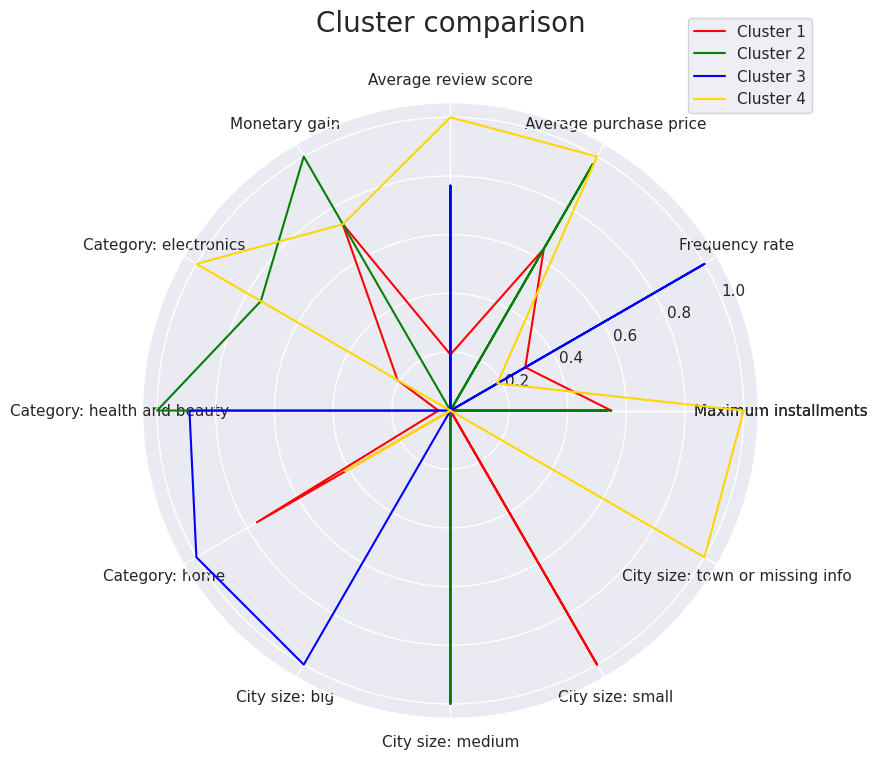

In [149]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_1, label='Cluster 1',c='red')
plt.plot(label_loc, cluster_2, label='Cluster 2',c='green')
plt.plot(label_loc, cluster_3, label='Cluster 3',c='blue')
plt.plot(label_loc, cluster_4, label='Cluster 4', c='gold')
plt.title('Cluster comparison\n', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.15))
plt.show()

In [150]:
!ls '/content/My Drive'

ls: cannot access '/content/My Drive': No such file or directory


In [151]:
data_var.to_csv(path+'data/4_cluster_data.csv')

In [152]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cluster_1,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_2,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_3,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.add_trace(go.Scatterpolar(
      r=cluster_4,
      theta=categories,
      fill='toself',
      name='Cluster 4'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

## Cluster Stability and ARI Score

In [153]:
#data_var = pd.read_csv(path+'data/5_cluster_data.csv')

In [154]:
#data_var.set_index('customer_id', inplace=True)

In [155]:
dates = {}
for idx, row in client_data.iterrows():
  dates[row['customer_id']] = row['order_purchase_timestamp']

In [156]:
data_var['order_purchase_timestamp'] = data_var.index.to_series().map(dates)

In [157]:
print("Date du dernier achat", data_var.order_purchase_timestamp.max())
print("Date du premier achat", data_var.order_purchase_timestamp.min())

Date du dernier achat 2018-08-28 14:37:52
Date du premier achat 2016-10-03 09:44:50


In [158]:
data_var.order_purchase_timestamp = data_var.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [159]:
data_var.order_purchase_timestamp = data_var.order_purchase_timestamp.apply(lambda x: x.date())

In [160]:
data_var[data_var['frequency'] > 1]['Cluster'].unique()

array([3, 1, 0, 2], dtype=int32)

In [161]:
# Initial period = 6 months
df0 = data_var[data_var.order_purchase_timestamp <= (data_var.order_purchase_timestamp.min() + DateOffset(months=3))]

<ipython-input-161-ef55f12f6ee4>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [162]:
#df0.drop(columns=['order_purchase_timestamp', 'Cluster'], inplace=True)
df0.drop(columns=['order_purchase_timestamp'], inplace=True)

<ipython-input-162-78df0d36165b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [163]:
#var_thr = VarianceThreshold(threshold = 0.1) # remove constant and quasi-constant variables where 90% of the values are similar
#var_thr.fit(df0)
#concol = [column for column in df0.columns if column not in df0.columns[var_thr.get_support()]]
#print(concol)

In [164]:
#df0.drop(concol, axis=1, inplace=True)

In [165]:
mm = MinMaxScaler()
df0 = pd.DataFrame(data=mm.fit_transform(df0), columns=df0.columns, index=df0.index)

In [166]:
df0

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
dc607dc98d6a11d5d04d9f2a70aa6c34,0.3,0.000000,0.261084,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.984127,0.0,0.429453,0.000000
7615536f9443d90e9971a9002fd9abf5,0.1,0.666667,0.477416,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.944444,0.0,0.559013,0.666667
da1c9a7e7fa9de1d48ecd6d6e027313e,0.1,0.166667,0.196665,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.976190,0.0,0.364807,1.000000
e2c852f36be265c817eafd880884b206,0.1,0.000000,0.151156,1.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.920635,0.0,0.300429,0.000000
a17dc8aaea9743dbccaca067b5ac3b43,0.1,0.166667,0.166351,0.50,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.976190,0.0,0.337178,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94b216231ec09ee34764a8d456126328,0.3,0.833333,0.109890,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.928571,0.0,0.270655,0.333333
b30a4d09f171b5da553bab49a0a61764,0.2,1.000000,0.022357,1.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.920635,0.0,0.054989,1.000000
407136bd5649e73981dce394b201897d,1.0,0.500000,0.355817,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.968254,0.0,0.491148,1.000000


In [167]:
ari_score = []
for i in range(0, 24, 3):
  df_i = calc_period(data_var, i)
  df_i_clus = df_i.drop(columns=['Cluster'])
  #print(df_i_clus.head())
  common_indices = df_i.index.intersection(df0.index)
  df_i_clus = df_i_clus.loc[common_indices]
  print(df_i_clus.shape, df0.shape)
  predicted_labels = calcKmeans(df_i_clus)
  ari_i = adjusted_rand_score(df0['Cluster'].tolist(), predicted_labels)
  ari_score.append([i, ari_i])
  df0 = df_i

<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target

<ipython-input-6-d

(161, 16) (161, 17)


<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



(161, 16) (161, 17)


<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(3485, 16) (3485, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(9603, 16) (9603, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(17982, 16) (17982, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(29653, 16) (29653, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(43366, 16) (43366, 17)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



(55885, 16) (55885, 17)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [168]:
ari_score = pd.DataFrame(ari_score, columns=["period", "ARI"] )
ari_score

,period,ARI
0,0,0.717269
1,3,0.717269
2,6,0.003277
3,9,0.000422
4,12,0.000054
5,15,0.000135
6,18,-0.000031
7,21,0.000015


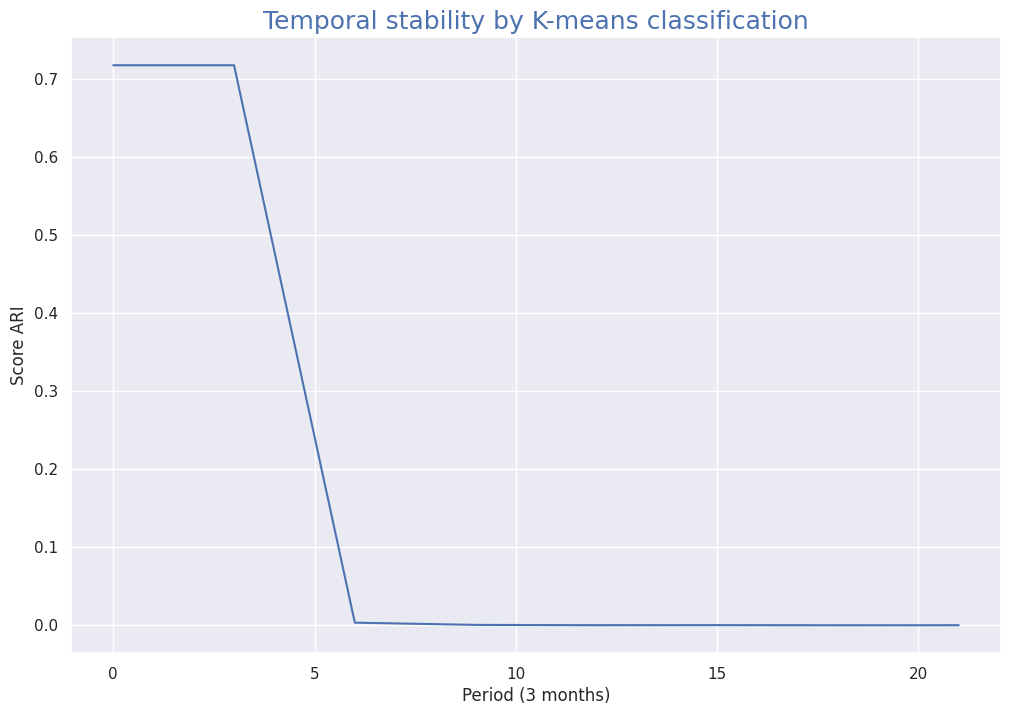

In [169]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="period", y="ARI")

plt.xlabel("Period (3 months)")
plt.ylabel("Score ARI")
plt.title("Temporal stability by K-means classification",
          fontsize=18,
          color="b")
plt.show()

## Slhouette plot

In [170]:
kmean_transformed_model

KMeans(max_iter=1000, n_clusters=4, random_state=20)

In [171]:
from yellowbrick.cluster import SilhouetteVisualizer

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(max_iter=1000, n_clusters=5, n_init=10,
                                      random_state=42))

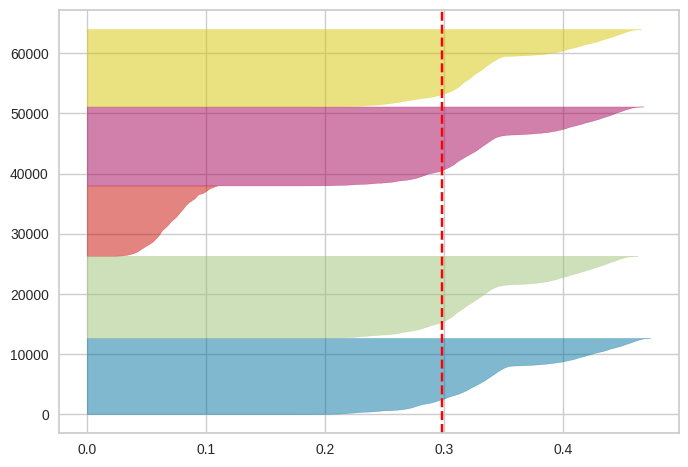

In [172]:
#fig, ax = plt.figure(figsize=(15, 8))
i = 5
km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=1000, random_state=42)
q, mod = divmod(i, 2)
'''
Create SilhouetteVisualizer instance with KMeans instance
Fit the visualizer
'''
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(data_var_scaled)

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(max_iter=1000, n_clusters=4, n_init=10,
                                      random_state=42))

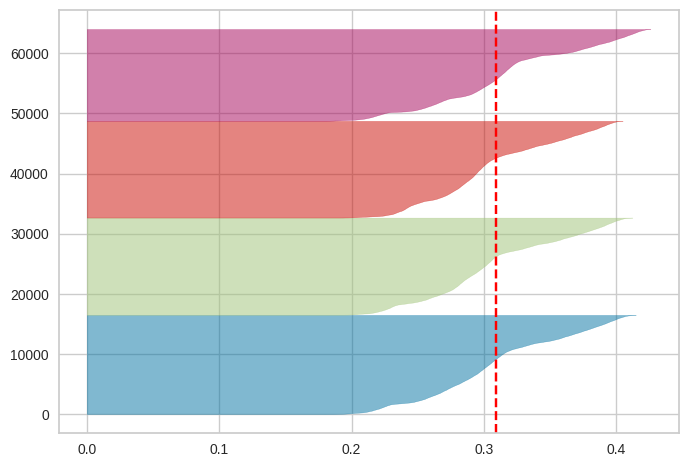

In [173]:
#fig, ax = plt.figure(figsize=(15, 8))
i = 4
km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=1000, random_state=42)
q, mod = divmod(i, 2)
'''
Create SilhouetteVisualizer instance with KMeans instance
Fit the visualizer
'''
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(data_var_scaled)

## ARI Score on 4 cluster data

In [176]:
data_var = pd.read_csv(path+'data/4_cluster_data.csv')

In [177]:
data_var.set_index('customer_id', inplace=True)

In [178]:
dates = {}
for idx, row in client_data.iterrows():
  dates[row['customer_id']] = row['order_purchase_timestamp']

In [179]:
data_var['order_purchase_timestamp'] = data_var.index.to_series().map(dates)

In [180]:
print("Date du dernier achat", data_var.order_purchase_timestamp.max())
print("Date du premier achat", data_var.order_purchase_timestamp.min())

Date du dernier achat 2018-08-28 14:37:52
Date du premier achat 2016-10-03 09:44:50


In [181]:
data_var.order_purchase_timestamp = data_var.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [182]:
data_var.order_purchase_timestamp = data_var.order_purchase_timestamp.apply(lambda x: x.date())

In [183]:
data_var[data_var['frequency'] > 1]['Cluster'].unique()

array([3, 1, 0, 2])

In [184]:
# Initial period = 6 months
df0 = data_var[data_var.order_purchase_timestamp <= (data_var.order_purchase_timestamp.min() + DateOffset(months=3))]

<ipython-input-184-ef55f12f6ee4>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [185]:
#df0.drop(columns=['order_purchase_timestamp', 'Cluster'], inplace=True)
df0.drop(columns=['order_purchase_timestamp'], inplace=True)

<ipython-input-185-78df0d36165b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
#var_thr = VarianceThreshold(threshold = 0.1) # remove constant and quasi-constant variables where 90% of the values are similar
#var_thr.fit(df0)
#concol = [column for column in df0.columns if column not in df0.columns[var_thr.get_support()]]
#print(concol)

In [187]:
#df0.drop(concol, axis=1, inplace=True)

In [188]:
mm = MinMaxScaler()
df0 = pd.DataFrame(data=mm.fit_transform(df0), columns=df0.columns, index=df0.index)

In [189]:
df0

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary,Cluster
customer_id,,,,,,,,,,,,,,,,,
dc607dc98d6a11d5d04d9f2a70aa6c34,0.3,0.000000,0.261084,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.984127,0.0,0.429453,0.000000
7615536f9443d90e9971a9002fd9abf5,0.1,0.666667,0.477416,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.944444,0.0,0.559013,0.666667
da1c9a7e7fa9de1d48ecd6d6e027313e,0.1,0.166667,0.196665,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.976190,0.0,0.364807,1.000000
e2c852f36be265c817eafd880884b206,0.1,0.000000,0.151156,1.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.920635,0.0,0.300429,0.000000
a17dc8aaea9743dbccaca067b5ac3b43,0.1,0.166667,0.166351,0.50,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.976190,0.0,0.337178,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94b216231ec09ee34764a8d456126328,0.3,0.833333,0.109890,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.928571,0.0,0.270655,0.333333
b30a4d09f171b5da553bab49a0a61764,0.2,1.000000,0.022357,1.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.920635,0.0,0.054989,1.000000
407136bd5649e73981dce394b201897d,1.0,0.500000,0.355817,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.968254,0.0,0.491148,1.000000


In [190]:
ari_score = []
for i in range(0, 24, 3):
  df_i = calc_period(data_var, i)
  df_i_clus = df_i.drop(columns=['Cluster'])
  #print(df_i_clus.head())
  common_indices = df_i.index.intersection(df0.index)
  df_i_clus = df_i_clus.loc[common_indices]
  print(df_i_clus.shape, df0.shape)
  predicted_labels = calcKmeans(df_i_clus)
  ari_i = adjusted_rand_score(df0['Cluster'].tolist(), predicted_labels)
  ari_score.append([i, ari_i])
  df0 = df_i

<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target

<ipython-input-6-d

(161, 16) (161, 17)


<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(161, 16) (161, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(3485, 16) (3485, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(9603, 16) (9603, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(17982, 16) (17982, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(29653, 16) (29653, 17)


<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-6-db3369d50c20>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(43366, 16) (43366, 17)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-6-db3369d50c20>:2: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



(55885, 16) (55885, 17)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [191]:
ari_score = pd.DataFrame(ari_score, columns=["period", "ARI"] )
ari_score

,period,ARI
0,0,0.717269
1,3,0.717269
2,6,0.003277
3,9,0.000422
4,12,0.000054
5,15,0.000135
6,18,-0.000031
7,21,0.000015


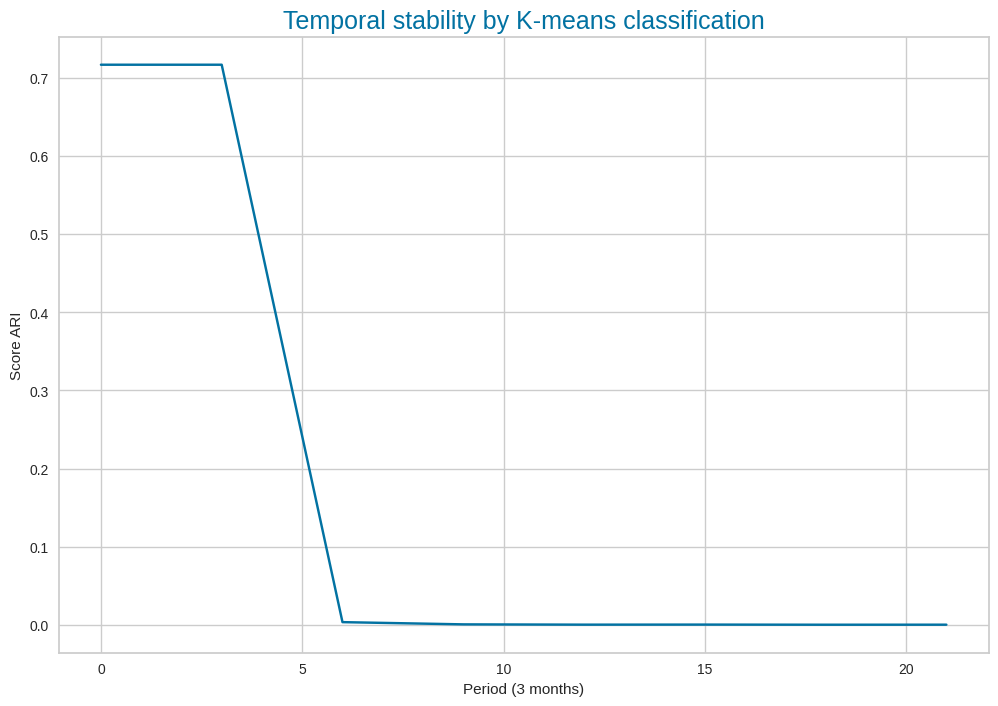

In [192]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="period", y="ARI")

plt.xlabel("Period (3 months)")
plt.ylabel("Score ARI")
plt.title("Temporal stability by K-means classification",
          fontsize=18,
          color="b")
plt.show()

### Testing a counter algorithm on the targeted dataset

In [193]:
data_var_scaled

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary
0,0.041667,0.333333,0.285859,1.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.795232,0.0,0.584774
1,0.083333,0.666667,0.166757,1.00,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.924511,0.0,0.540473
2,0.125000,0.000000,0.322470,1.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.942848,0.0,0.600853
3,0.041667,0.333333,0.431432,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.849175,0.0,0.633122
4,0.083333,0.000000,0.123665,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.807304,0.0,0.505797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63976,0.083333,0.500000,0.285171,0.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.744957,0.0,0.593087
63977,0.041667,0.666667,0.101937,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.860024,0.0,0.509079
63978,0.041667,1.000000,0.721130,1.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.854370,0.0,0.679720
63979,0.041667,0.666667,0.181423,0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.642573,0.0,0.553927


In [194]:
X = data_var_scaled.sample(frac=1).head(10000)

In [195]:
X

,max_installments,order_purchase_day,avg_purchase_price,avg_review_score,electronics,health_beauty,home,boleto,credit_card,big city,medium city,small city,towns or missing info,recency,frequency,monetary
56754,0.041667,0.166667,0.087380,0.75,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.932916,0.185393,0.643295
54121,0.041667,0.333333,0.322470,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.882488,0.185393,0.606869
22403,0.250000,0.333333,0.174000,1.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.860483,0.000000,0.569569
35937,0.208333,1.000000,0.322470,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.790954,0.000000,0.600853
2043,0.041667,0.000000,0.214159,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.832366,0.185393,0.720521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,0.250000,0.833333,0.177621,0.50,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.758405,0.000000,0.551739
46547,0.041667,1.000000,0.123303,1.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.926650,0.000000,0.520674
34724,0.041667,0.666667,0.241173,0.25,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.743888,0.185393,0.736272
7588,0.000000,1.000000,0.279377,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.893032,0.185393,0.742726


In [196]:
X.reset_index(drop=True, inplace=True)

Estimated number of clusters: 1


Text(0, 0.5, 'Feature 2')

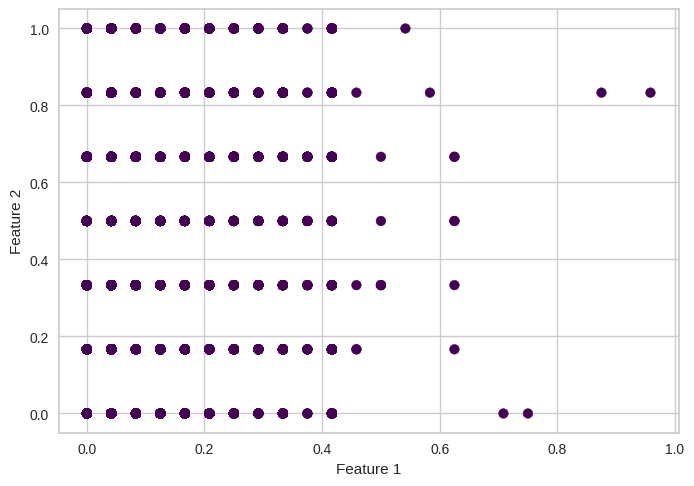

In [197]:
meanshift = MeanShift(bandwidth=100)
meanshift.fit(X)
labels = meanshift.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print('Estimated number of clusters: ' + str(n_clusters_))

y_pred  = meanshift.predict(X)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred, cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [198]:
from sklearn.cluster import DBSCAN

In [212]:
db = DBSCAN(eps=0.3, min_samples=100).fit(X)

In [213]:
labels = db.labels_

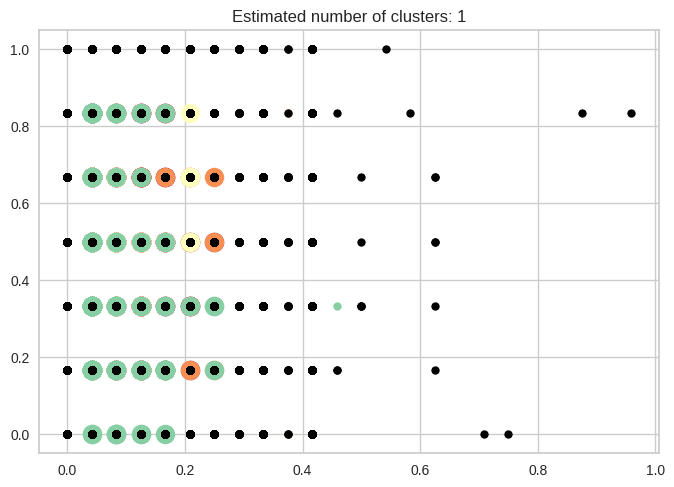

In [214]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()